# Session 3 — Sentence-Level Analysis
## Measure 3: Sentence Embeddings (LLMs as Semantic Encoders)
### BONUS: Comparative Analysis of Alice's Adventures in Wonderland and Through the Looking-Glass

> **Note:** This is an **advanced extension** of notebook `3_1_AppliedNLP_Session3_Sentence_Embeddings.ipynb`. 
> Complete the basic notebook first to understand the fundamentals of sentence embeddings before working through this more complex literary analysis.

---

### What This Bonus Notebook Covers
This advanced demonstration applies sentence embeddings to **real literary texts**, analyzing Lewis Carroll's two Alice books:
- Extracts and compares key sentences from both novels
- Performs multi-dimensional visualization (2D, 3D)
- Automatically discovers thematic clusters
- Quantifies cross-book semantic similarities
- Provides comparative literary analysis

### Prerequisites
Before starting this notebook, you should:
- Complete notebook `3_1` and understand basic sentence embeddings
- Be familiar with PCA (Principal Component Analysis)
- Understand cosine similarity metrics
- Have the Alice books in the `../data/` folder

---

### Quick Review: What are Sentence Embeddings?
Sentence embeddings are **dense vector representations** of sentences that capture their semantic meaning in a high-dimensional space. Unlike traditional word-based approaches, sentence embeddings encode the entire meaning of a sentence into a single fixed-length vector (typically 384-768 dimensions).

### How They Work
Modern sentence embedding models (like SBERT - Sentence-BERT) use **transformer architectures** pre-trained on massive text corpora. These models:
- Convert sentences into numerical vectors where semantically similar sentences are close together in vector space
- Capture context, syntax, and semantic relationships
- Enable comparison of sentences based on meaning rather than just word overlap

### Key Applications in NLP
1. **Semantic Similarity**: Measure how similar two sentences are in meaning
2. **Information Retrieval**: Find relevant documents or passages based on semantic search
3. **Text Clustering**: Group similar sentences or documents together
4. **Duplicate Detection**: Identify paraphrases or semantically identical content
5. **Question Answering**: Match questions with relevant answers
6. **Content Recommendation**: Suggest similar content based on semantic understanding
7. **Comparative Literary Analysis**: Compare themes, writing styles, and narrative patterns across texts

### This Advanced Demonstration
We'll use the **all-MiniLM-L6-v2** model to:
- Extract key sentences from both Alice books using extractive summarization
- Encode sentences into semantic vectors
- Visualize thematic relationships between the two books in 2D/3D space
- Identify semantic similarities and differences between the narratives
- Cluster sentences by themes (e.g., size changes, absurdity, dialogue, fantasy)
- Perform quantitative comparative literature analysis

In [10]:
# Import necessary libraries
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import re
import nltk
from collections import Counter

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [11]:
# Load the two Alice books
def load_book(filepath):
    """Load and clean book text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Remove Project Gutenberg headers/footers
    start_markers = ['*** START OF', 'CHAPTER I']
    end_markers = ['*** END OF', 'End of Project Gutenberg']
    
    # Find start
    for marker in start_markers:
        if marker in text:
            start = text.find(marker)
            if marker == 'CHAPTER I':
                text = text[start:]
            else:
                text = text[start + len(marker):]
            break
    
    # Find end
    for marker in end_markers:
        if marker in text:
            end = text.find(marker)
            text = text[:end]
            break
    
    return text

# Load both books
wonderland_text = load_book('../data/Wonderland.txt')
looking_glass_text = load_book('../data/Looking-Glass.txt')

print(f"Alice's Adventures in Wonderland: {len(wonderland_text):,} characters")
print(f"Through the Looking-Glass: {len(looking_glass_text):,} characters")

Alice's Adventures in Wonderland: 144,638 characters
Through the Looking-Glass: 164,313 characters


In [12]:
# Extract meaningful sentences from both books
def extract_key_sentences(text, n_sentences=30):
    """
    Extract key sentences using a simple extractive approach:
    - Filter by length (not too short, not too long)
    - Prefer sentences with dialogue or interesting content
    - Avoid repetitive patterns
    """
    # Split into sentences
    sentences = nltk.sent_tokenize(text)
    
    # Clean and filter sentences
    filtered = []
    for sent in sentences:
        # Remove extra whitespace
        sent = ' '.join(sent.split())
        
        # Filter criteria
        word_count = len(sent.split())
        if word_count < 8 or word_count > 40:  # Not too short or long
            continue
        if sent.startswith('CHAPTER'):  # Skip chapter headers
            continue
        if re.match(r'^[IVX]+\.', sent):  # Skip Roman numerals
            continue
        
        filtered.append(sent)
    
    # Score sentences based on interesting features
    scores = []
    for sent in filtered:
        score = 0
        
        # Dialogue is interesting
        if '"' in sent or '"' in sent or '"' in sent:
            score += 2
        
        # Questions are interesting
        if '?' in sent:
            score += 1
        
        # Exclamations add emotion
        if '!' in sent:
            score += 1
        
        # Prefer sentences with Alice
        if 'Alice' in sent:
            score += 1
        
        # Length sweet spot
        word_count = len(sent.split())
        if 12 <= word_count <= 25:
            score += 1
        
        scores.append(score)
    
    # Get top N sentences by score
    scored_sentences = list(zip(filtered, scores))
    scored_sentences.sort(key=lambda x: x[1], reverse=True)
    
    # Return top sentences (without duplicates)
    top_sentences = []
    for sent, score in scored_sentences[:n_sentences * 2]:
        if sent not in top_sentences:
            top_sentences.append(sent)
        if len(top_sentences) >= n_sentences:
            break
    
    return top_sentences

# Extract key sentences from both books
n_per_book = 25
wonderland_sentences = extract_key_sentences(wonderland_text, n_per_book)
looking_glass_sentences = extract_key_sentences(looking_glass_text, n_per_book)

print(f"Extracted {len(wonderland_sentences)} key sentences from Wonderland")
print(f"Extracted {len(looking_glass_sentences)} key sentences from Looking-Glass")
print(f"\nTotal sentences to analyze: {len(wonderland_sentences) + len(looking_glass_sentences)}")

# Show a few examples
print("\n" + "="*80)
print("SAMPLE FROM WONDERLAND:")
print("="*80)
for i, sent in enumerate(wonderland_sentences[:3], 1):
    print(f"{i}. {sent}")

print("\n" + "="*80)
print("SAMPLE FROM LOOKING-GLASS:")
print("="*80)
for i, sent in enumerate(looking_glass_sentences[:3], 1):
    print(f"{i}. {sent}")

Extracted 25 key sentences from Wonderland
Extracted 25 key sentences from Looking-Glass

Total sentences to analyze: 50

SAMPLE FROM WONDERLAND:
1. How I wonder what you’re at!’ You know the song, perhaps?” “I’ve heard something like it,” said Alice.
2. “Well!” thought Alice to herself, “after such a fall as this, I shall think nothing of tumbling down stairs!
3. Please, Ma’am, is this New Zealand or Australia?” (and she tried to curtsey as she spoke—fancy _curtseying_ as you’re falling through the air!

SAMPLE FROM LOOKING-GLASS:
1. “Every single thing’s crooked,” Alice thought to herself, “and she’s all over pins!—may I put your shawl straight for you?” she added aloud.
2. “Feather, I say!” “_Why_ do you say ‘feather’ so often?” Alice asked at last, rather vexed.
3. How old did you say you were?” Alice made a short calculation, and said “Seven years and six months.” “Wrong!” Humpty Dumpty exclaimed triumphantly.


In [13]:
# Load sentence transformer model and generate embeddings
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine sentences and track their sources
all_sentences = wonderland_sentences + looking_glass_sentences
book_labels = ['Wonderland'] * len(wonderland_sentences) + ['Looking-Glass'] * len(looking_glass_sentences)

# Generate embeddings
print("Generating embeddings...")
embeddings = model.encode(all_sentences, show_progress_bar=True)

print(f"\nEmbedding shape: {embeddings.shape}")
print(f"Each sentence → {embeddings.shape[1]}-dimensional vector")

Loading sentence transformer model...
Generating embeddings...
Generating embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


Embedding shape: (50, 384)
Each sentence → 384-dimensional vector


In [14]:
# Perform clustering to identify themes
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

print(f"Identified {n_clusters} thematic clusters")
print("\nCluster distribution:")
for i in range(n_clusters):
    count = sum(clusters == i)
    wonderland_count = sum((clusters == i) & (np.array(book_labels) == 'Wonderland'))
    looking_glass_count = sum((clusters == i) & (np.array(book_labels) == 'Looking-Glass'))
    print(f"  Cluster {i}: {count} sentences (W:{wonderland_count}, LG:{looking_glass_count})")

Identified 5 thematic clusters

Cluster distribution:
  Cluster 0: 2 sentences (W:0, LG:2)
  Cluster 1: 11 sentences (W:2, LG:9)
  Cluster 2: 26 sentences (W:12, LG:14)
  Cluster 3: 9 sentences (W:9, LG:0)
  Cluster 4: 2 sentences (W:2, LG:0)


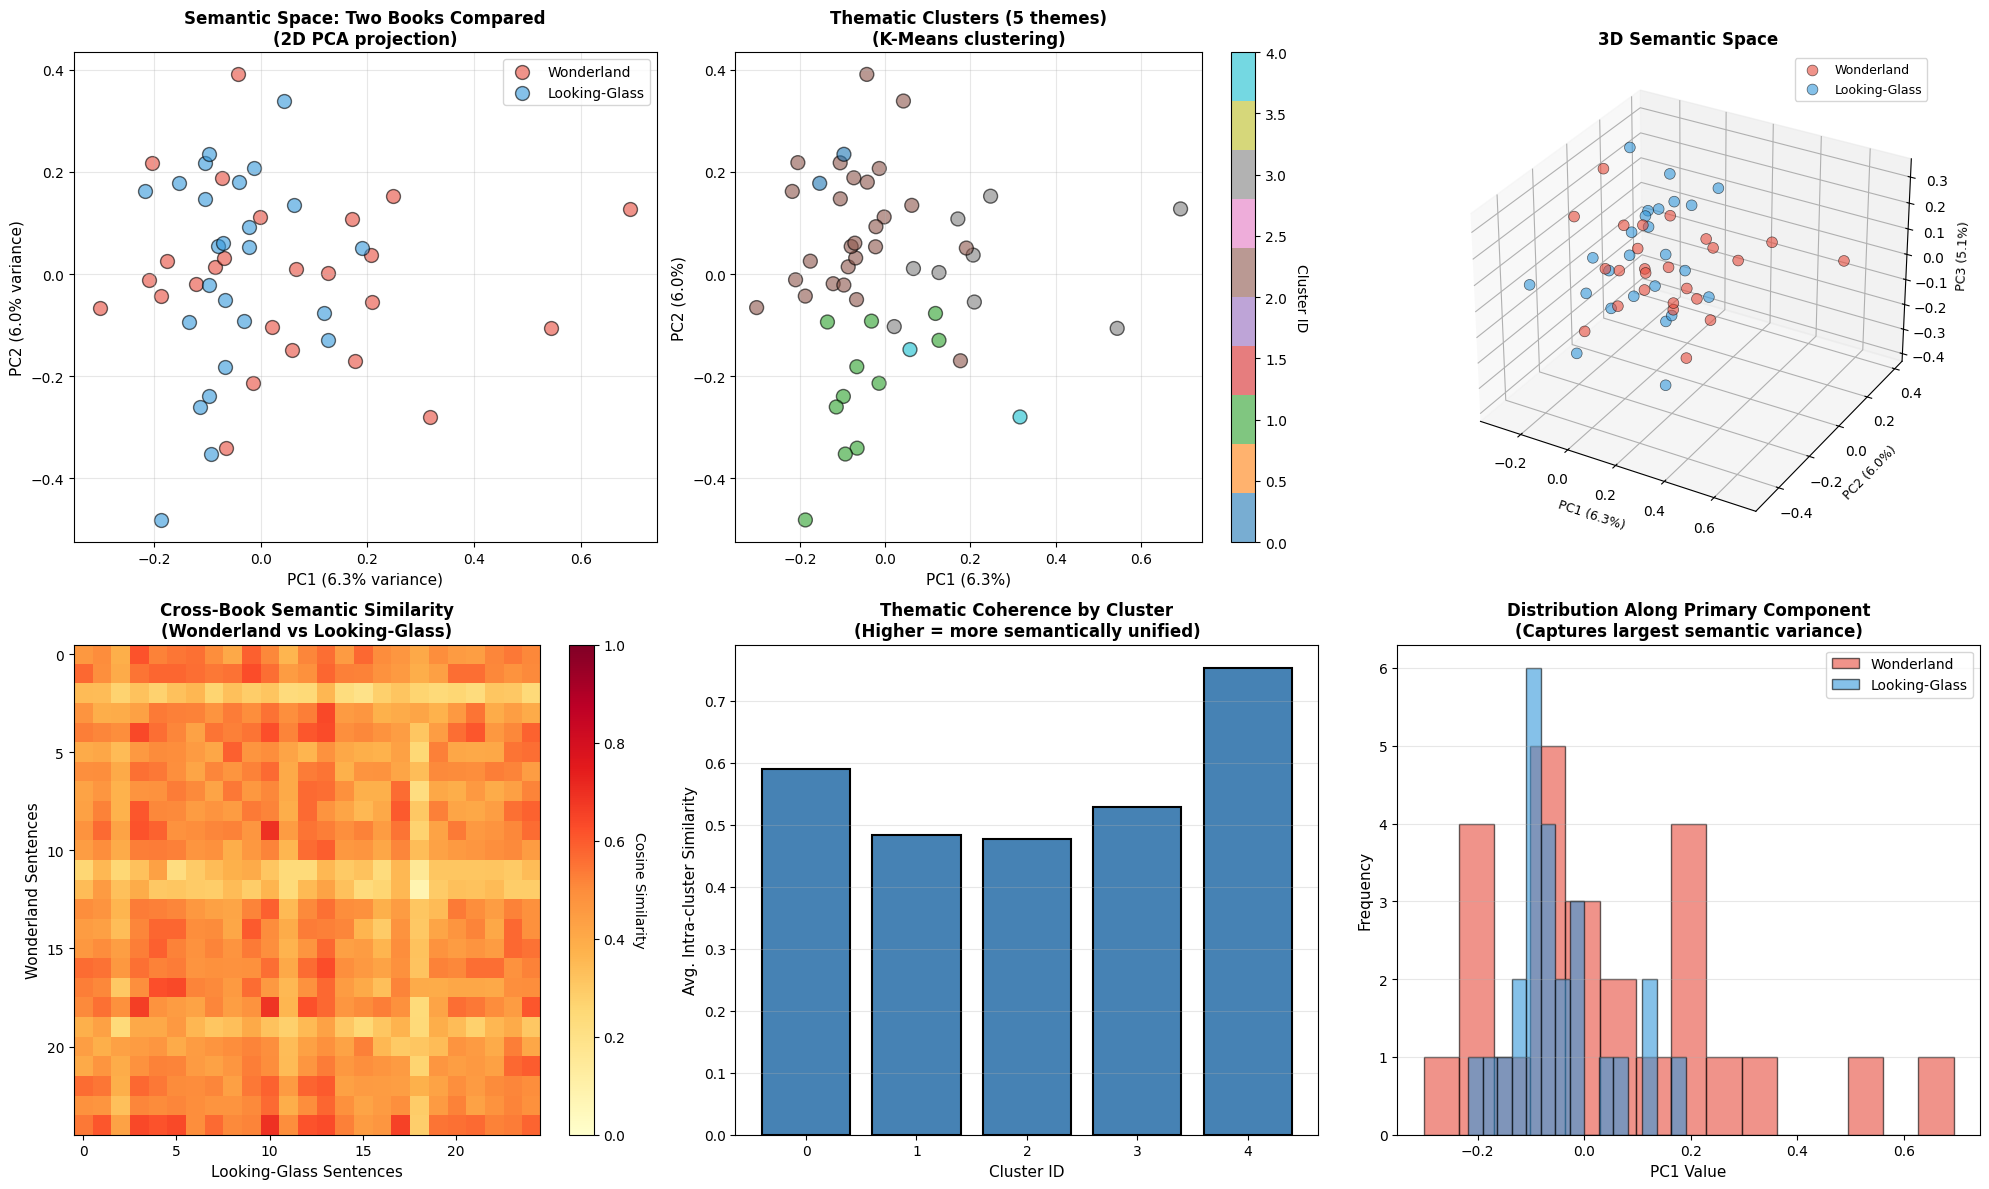

In [15]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# Define colors for the two books
colors_dict = {'Wonderland': '#e74c3c', 'Looking-Glass': '#3498db'}
colors = [colors_dict[label] for label in book_labels]

# --- Plot 1: 2D PCA with book distinction ---
ax1 = plt.subplot(2, 3, 1)
pca_2d = PCA(n_components=2)
points_2d = pca_2d.fit_transform(embeddings)

for book in ['Wonderland', 'Looking-Glass']:
    mask = np.array(book_labels) == book
    ax1.scatter(points_2d[mask, 0], points_2d[mask, 1], 
               c=colors_dict[book], label=book, alpha=0.6, s=100, edgecolors='black', linewidth=1)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('Semantic Space: Two Books Compared\n(2D PCA projection)', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- Plot 2: 2D PCA with clusters ---
ax2 = plt.subplot(2, 3, 2)
scatter = ax2.scatter(points_2d[:, 0], points_2d[:, 1], c=clusters, 
                     cmap='tab10', alpha=0.6, s=100, edgecolors='black', linewidth=1)
ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax2.set_title(f'Thematic Clusters ({n_clusters} themes)\n(K-Means clustering)', 
             fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Cluster ID', rotation=270, labelpad=15)
ax2.grid(True, alpha=0.3)

# --- Plot 3: 3D PCA ---
ax3 = plt.subplot(2, 3, 3, projection='3d')
pca_3d = PCA(n_components=3)
points_3d = pca_3d.fit_transform(embeddings)

for book in ['Wonderland', 'Looking-Glass']:
    mask = np.array(book_labels) == book
    ax3.scatter(points_3d[mask, 0], points_3d[mask, 1], points_3d[mask, 2],
               c=colors_dict[book], label=book, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

ax3.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=9)
ax3.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=9)
ax3.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=9)
ax3.set_title('3D Semantic Space', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)

# --- Plot 4: Cross-book similarity matrix ---
ax4 = plt.subplot(2, 3, 4)

# Compute similarity between Wonderland and Looking-Glass
wonderland_embeddings = embeddings[:len(wonderland_sentences)]
looking_glass_embeddings = embeddings[len(wonderland_sentences):]
cross_similarity = util.cos_sim(wonderland_embeddings, looking_glass_embeddings).numpy()

im = ax4.imshow(cross_similarity, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=15, fontsize=10)
ax4.set_xlabel('Looking-Glass Sentences', fontsize=11)
ax4.set_ylabel('Wonderland Sentences', fontsize=11)
ax4.set_title('Cross-Book Semantic Similarity\n(Wonderland vs Looking-Glass)', 
             fontsize=12, fontweight='bold')

# --- Plot 5: Average similarity per cluster ---
ax5 = plt.subplot(2, 3, 5)

cluster_similarities = []
for i in range(n_clusters):
    cluster_mask = clusters == i
    if sum(cluster_mask) > 1:
        cluster_emb = embeddings[cluster_mask]
        sim_matrix = util.cos_sim(cluster_emb, cluster_emb).numpy()
        # Average similarity (excluding diagonal)
        avg_sim = (sim_matrix.sum() - sim_matrix.trace()) / (sim_matrix.size - len(cluster_emb))
        cluster_similarities.append(avg_sim)
    else:
        cluster_similarities.append(0)

bars = ax5.bar(range(n_clusters), cluster_similarities, color='steelblue', edgecolor='black', linewidth=1.5)
ax5.set_xlabel('Cluster ID', fontsize=11)
ax5.set_ylabel('Avg. Intra-cluster Similarity', fontsize=11)
ax5.set_title('Thematic Coherence by Cluster\n(Higher = more semantically unified)', 
             fontsize=12, fontweight='bold')
ax5.set_xticks(range(n_clusters))
ax5.grid(True, alpha=0.3, axis='y')

# --- Plot 6: Distribution histogram ---
ax6 = plt.subplot(2, 3, 6)

wonderland_pc1 = points_2d[:len(wonderland_sentences), 0]
looking_glass_pc1 = points_2d[len(wonderland_sentences):, 0]

ax6.hist(wonderland_pc1, bins=15, alpha=0.6, color='#e74c3c', label='Wonderland', edgecolor='black')
ax6.hist(looking_glass_pc1, bins=15, alpha=0.6, color='#3498db', label='Looking-Glass', edgecolor='black')
ax6.set_xlabel('PC1 Value', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Distribution Along Primary Component\n(Captures largest semantic variance)', 
             fontsize=12, fontweight='bold')
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Interpreting the Visualizations

**Top Left - Book Comparison (2D):**
- Red points = Alice's Adventures in Wonderland
- Blue points = Through the Looking-Glass
- Spatial proximity indicates semantic similarity
- Overlapping regions suggest shared themes between books

**Top Middle - Thematic Clusters:**
- Color-coded by automatically detected themes
- K-Means clustering groups semantically similar sentences
- Reveals common narrative patterns across both books

**Top Right - 3D Semantic Space:**
- Three-dimensional view captures more variance
- Rotation would show different perspectives on semantic relationships
- Preserves more information than 2D projection

**Bottom Left - Cross-Book Similarity Matrix:**
- Heat map showing similarity between every Wonderland sentence and every Looking-Glass sentence
- Bright areas indicate highly similar passages
- Reveals which scenes/themes are shared across books

**Bottom Middle - Cluster Coherence:**
- Measures how semantically unified each theme cluster is
- Higher bars = sentences in that cluster are more similar to each other
- Indicates strength of thematic grouping

**Bottom Right - Distribution Analysis:**
- Shows how the books differ along the primary semantic dimension
- Overlapping distributions suggest similar semantic content
- Separated peaks would indicate distinct narrative styles

In [16]:
# Analyze each cluster to understand themes
print("="*80)
print("THEMATIC ANALYSIS OF CLUSTERS")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_mask = clusters == cluster_id
    cluster_sentences = [sent for sent, mask in zip(all_sentences, cluster_mask) if mask]
    cluster_books = [book for book, mask in zip(book_labels, cluster_mask) if mask]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {len(cluster_sentences)} sentences")
    print(f"  Wonderland: {cluster_books.count('Wonderland')}, Looking-Glass: {cluster_books.count('Looking-Glass')}")
    print(f"{'='*80}")
    
    # Show representative sentences (up to 3)
    for i, (sent, book) in enumerate(zip(cluster_sentences[:3], cluster_books[:3]), 1):
        book_abbr = "W" if book == "Wonderland" else "LG"
        # Truncate if too long
        display_sent = sent if len(sent) < 100 else sent[:97] + "..."
        print(f"{i}. [{book_abbr}] {display_sent}")
    
    if len(cluster_sentences) > 3:
        print(f"   ... and {len(cluster_sentences) - 3} more sentences")

THEMATIC ANALYSIS OF CLUSTERS

CLUSTER 0: 2 sentences
  Wonderland: 0, Looking-Glass: 2
1. [LG] “Next Boy!” said Alice, passing on to Tweedledee, though she felt quite certain he would only sho...
2. [LG] “You see he held his handkerchief in front, so that the Carpenter couldn’t count how many he took...

CLUSTER 1: 11 sentences
  Wonderland: 2, Looking-Glass: 9
1. [W] “What else have you got in your pocket?” he went on, turning to Alice.
2. [W] “A knot!” said Alice, always ready to make herself useful, and looking anxiously about her.
3. [LG] There now!” “Is it really?” said Alice, quite pleased to find that she _had_ chosen a good subjec...
   ... and 8 more sentences

CLUSTER 2: 26 sentences
  Wonderland: 12, Looking-Glass: 14
1. [W] How I wonder what you’re at!’ You know the song, perhaps?” “I’ve heard something like it,” said A...
2. [W] “Well!” thought Alice to herself, “after such a fall as this, I shall think nothing of tumbling d...
3. [W] Please, Ma’am, is this New Zealand or

In [17]:
# Find most similar cross-book sentence pairs
print("="*80)
print("MOST SIMILAR SENTENCES ACROSS BOOKS")
print("="*80)
print("Finding thematic parallels between Wonderland and Looking-Glass...\n")

# Get cross-book similarities
wonderland_embeddings = embeddings[:len(wonderland_sentences)]
looking_glass_embeddings = embeddings[len(wonderland_sentences):]
cross_similarity = util.cos_sim(wonderland_embeddings, looking_glass_embeddings).numpy()

# Find top 5 most similar pairs
pairs = []
for i in range(len(wonderland_sentences)):
    for j in range(len(looking_glass_sentences)):
        pairs.append((i, j, cross_similarity[i, j]))

pairs.sort(key=lambda x: x[2], reverse=True)

for rank, (i, j, score) in enumerate(pairs[:5], 1):
    print(f"{rank}. Similarity: {score:.4f}")
    print(f"   [Wonderland] {wonderland_sentences[i][:120]}...")
    print(f"   [Looking-Glass] {looking_glass_sentences[j][:120]}...")
    print()

MOST SIMILAR SENTENCES ACROSS BOOKS
Finding thematic parallels between Wonderland and Looking-Glass...

1. Similarity: 0.6949
   [Wonderland] Don’t let me hear the name again!” “I won’t indeed!” said Alice, in a great hurry to change the subject of conversation....
   [Looking-Glass] Don’t try to talk!” Not that Alice had any idea of doing _that_....

2. Similarity: 0.6923
   [Wonderland] Oh, I shouldn’t like _that!_” “Oh, you foolish Alice!” she answered herself....
   [Looking-Glass] Don’t try to talk!” Not that Alice had any idea of doing _that_....

3. Similarity: 0.6854
   [Wonderland] “You insult me by talking such nonsense!” “I didn’t mean it!” pleaded poor Alice....
   [Looking-Glass] Don’t try to talk!” Not that Alice had any idea of doing _that_....

4. Similarity: 0.6632
   [Wonderland] “You insult me by talking such nonsense!” “I didn’t mean it!” pleaded poor Alice....
   [Looking-Glass] “You never said a word like it!” “I though you meant ‘How old _are_ you?’” Alice explai

In [18]:
# Analyze average within-book vs cross-book similarity
wonderland_sim = util.cos_sim(wonderland_embeddings, wonderland_embeddings).numpy()
looking_glass_sim = util.cos_sim(looking_glass_embeddings, looking_glass_embeddings).numpy()

# Calculate averages (excluding diagonal for within-book)
def avg_similarity_no_diag(matrix):
    return (matrix.sum() - matrix.trace()) / (matrix.size - len(matrix))

avg_wonderland = avg_similarity_no_diag(wonderland_sim)
avg_looking_glass = avg_similarity_no_diag(looking_glass_sim)
avg_cross_book = cross_similarity.mean()

print("="*80)
print("COMPARATIVE SIMILARITY ANALYSIS")
print("="*80)
print(f"Average within-book similarity (Wonderland):     {avg_wonderland:.4f}")
print(f"Average within-book similarity (Looking-Glass):  {avg_looking_glass:.4f}")
print(f"Average cross-book similarity:                   {avg_cross_book:.4f}")
print()

if avg_cross_book > min(avg_wonderland, avg_looking_glass) * 0.9:
    print("✓ The books show HIGH thematic overlap - similar narrative patterns and themes")
elif avg_cross_book > min(avg_wonderland, avg_looking_glass) * 0.7:
    print("≈ The books show MODERATE thematic overlap - some shared themes but distinct stories")
else:
    print("✗ The books show LOW thematic overlap - quite different in content and themes")

print("\nThis suggests that Lewis Carroll maintained", end=" ")
if avg_cross_book > 0.5:
    print("consistent themes and writing style across both Alice books.")
else:
    print("distinct approaches between the two Alice narratives.")

COMPARATIVE SIMILARITY ANALYSIS
Average within-book similarity (Wonderland):     0.4861
Average within-book similarity (Looking-Glass):  0.4344
Average cross-book similarity:                   0.4547

✓ The books show HIGH thematic overlap - similar narrative patterns and themes

This suggests that Lewis Carroll maintained distinct approaches between the two Alice narratives.


### Key Insights from This Analysis

**What We Discovered:**
1. **Semantic Embeddings** transform text into numbers while preserving meaning
2. **Dimensionality Reduction** (PCA) reveals hidden patterns in high-dimensional data
3. **Clustering** automatically discovers thematic groups without manual labeling
4. **Cross-book Analysis** quantifies narrative similarities between related texts

**Literary Applications:**
- **Authorship Analysis**: Detect writing style consistency across works
- **Theme Tracking**: Identify recurring motifs and narrative patterns
- **Comparative Literature**: Quantify similarities between different texts
- **Character Development**: Track how character representations evolve
- **Influence Detection**: Measure semantic similarity between works from different authors

**Limitations to Consider:**
- PCA dimensionality reduction loses information (check variance percentages)
- Sentence extraction is simplified - more sophisticated methods exist
- Context beyond sentence boundaries is not captured
- Model was trained on modern text, may not fully capture Victorian nuances
- Clustering number (k=5) was arbitrary - could be optimized

**Extensions You Could Try:**
- Analyze chapter-by-chapter semantic evolution
- Compare Alice books to other Victorian literature
- Track character-specific language patterns
- Identify dialogue vs. narrative differences
- Build a semantic search engine for the texts